In [17]:
!pip install opencv-python-headless 


[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: C:\Users\nicoc\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [2]:
import os

# Define la ruta a la carpeta que contiene los archivos .tiff
folder_path = '.\election_results\electoral_records'

# Define el porcentaje de archivos a procesar (por ejemplo, 50 para el 50%)
porcentaje_a_procesar = 20 #0.05

# Lista para almacenar las rutas completas de los archivos .tiff sin la extensión
tiff_files_info = []

# Recorrer todos los archivos en la carpeta especificada
for file in os.listdir(folder_path):
    if file.endswith('.tiff'):
        # Obtiene el nombre del archivo sin la extensión
        file_name_without_extension = os.path.splitext(file)[0]
        # Agrega un diccionario con la ruta completa y el nombre del archivo sin la extensión
        tiff_files_info.append({
            "path": os.path.join(folder_path, file),
            "file_name": file_name_without_extension
        })

# Calcula la cantidad de archivos a procesar basado en el porcentaje
num_files_to_process = int(len(tiff_files_info) * (porcentaje_a_procesar / 100))

# Selecciona un subconjunto de archivos para procesar basado en el porcentaje especificado
files_to_process = tiff_files_info[:num_files_to_process]

# Contar la cantidad de archivos .tiff
num_tiff_files = len(files_to_process)
print(f"Se encontraron {num_tiff_files} archivos .tiff")


# Imprime el listado de archivos con su ruta y nombre sin extensión
#for file_info in files_to_process:
#    print(f"Path: {file_info['path']}, File Name: {file_info['file_name']}")


Se encontraron 5992 archivos .tiff


In [5]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('./src/segmentation/')
sys.path.append('./src/data_management/')
sys.path.append('../segmentation_cropping/segmentation/')

from segmentation_cropping.segmentation.image_processor import ImageProcessor
import image_processor  # Importa tu módulo
import telegrama  # Importa tu módulo
import template  # Importa tu módulo
import election_data_downloader # Importa tu módulo

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


ModuleNotFoundError: No module named 'image_processor'

In [89]:
import os
import math
import cv2
import time
import random
from image_processor import ImageProcessor
from telegrama import Telegrama
from template import Template
from election_data_downloader import ElectionDataDownloader
from scrutiny_data_processor import ScrutinyDataProcessor
from election_image_storage import ElectionImageStorage

# Configuración inicial
FOLDER = "./files-examples/"
FILE_TELEGRAM_TEMPLATE = "generales_telegrama_01"
folder_path = './election_results/electoral_scope_data/'

# Instanciar la clase con el nombre de archivo donde se guardarán los datos
storage = ElectionImageStorage("processed_images.hdf5")

# Lista de índices de las celdas que quieres extraer
indices_celdas_a_extraer = [20, 29, 37, 45, 54, 92, 100, 108, 116, 124]

# Procesamiento de datos del escrutinio
mapeo_codigos_a_indices = {
    '132': 20,
    '133': 29,
    '134': 37,
    '135': 45,
    '136': 54,
    'Nulos': 92,
    'Recurridos': 100,
    'Blancos': 108,
    'Impugnados': 116,
    'Total': 124
}

# Lista de nombres de archivo obtenidos previamente
file_names = [...]  # Debes tener una lista de nombres de archivos sin la extensión .tiff

# Lista para almacenar los resultados de cada archivo
dataset = []

# Bucle sobre cada archivo
for file_info in files_to_process:
    # Cargar los datos si ya han sido procesados y guardados
    data_already_stored = storage.load(file_info['file_name'])

    # Si ya se han cargado los datos, se salta este archivo
    if data_already_stored is not None:
        print(f"Archivo {file_info['file_name']} ya procesado, saltando...")
        continue
    
    # Procesamiento de la imagen
    processor = ImageProcessor(f"{FOLDER}{FILE_TELEGRAM_TEMPLATE}.png", file_info['path'])
    if processor.read_and_align_images():
        aligned_binarizada = processor.binarize_aligned_image()
        template_binarizada = processor.binarize_template_image()

        # Crear instancias de Telegrama o Template
        telegrama = Telegrama(processor.aligned_image, aligned_binarizada)
        template = Template(processor.img_template, template_binarizada)

        # Dibujar las celdas detectadas en 'tabla' y numerarlas después de ordenarlas
        tabla_numerada = cv2.cvtColor(telegrama.tabla_grande.recorte, cv2.COLOR_GRAY2BGR) 

        # Procesa la tabla y recibe una lista de objetos Celda
        celdas_procesadas = processor.process_table(template.tabla_grande.recorte)

        # Extraer imágenes de celdas
        imagenes_celdas_extraidas = processor.extract_cells_by_id(celdas_procesadas, indices_celdas_a_extraer, telegrama.tabla_grande.recorte)
        
        # Introduce un retraso aleatorio entre 3 y 9 segundos
        random_delay = random.randint(3, 9)
        print(f"Esperando {random_delay} segundos antes de descargar los datos para {FILE_TELEGRAM}.")
        time.sleep(random_delay)
        
        # Descargar datos JSON
        downloader = ElectionDataDownloader(folder_path, file_info['file_name'])
        json_data = downloader.get_or_download_data()

        processor = ScrutinyDataProcessor(json_data, file_info['file_name'], mapeo_codigos_a_indices, imagenes_celdas_extraidas)
        resultados_info = processor.extract_info()

        # Guardar los resultados usando el método save de la clase
        if storage.save(file_info, resultados_info):
            print(f"Datos de {file_info['file_name']} guardados con éxito.")
            
        # Agregar los resultados al dataset
        dataset.append(resultados_info)
    else:
        print(f"No se pudo alinear y procesar la imagen para el archivo {file_info['file_name']}")



Archivo 0100100001X ya procesado, saltando...
Archivo 0100100002X ya procesado, saltando...
Archivo 0100100003X ya procesado, saltando...
Archivo 0100100004X ya procesado, saltando...
Archivo 0100100006X ya procesado, saltando...
Archivo 0100100007X ya procesado, saltando...
Archivo 0100100008X ya procesado, saltando...
Archivo 0100100009X ya procesado, saltando...
Archivo 0100100010X ya procesado, saltando...
Archivo 0100100011X ya procesado, saltando...
Archivo 0100100012X ya procesado, saltando...
Archivo 0100100013X ya procesado, saltando...
Archivo 0100100014X ya procesado, saltando...
Archivo 0100100015X ya procesado, saltando...
Archivo 0100100016X ya procesado, saltando...
Archivo 0100100017X ya procesado, saltando...
Archivo 0100100018X ya procesado, saltando...
Archivo 0100100019X ya procesado, saltando...
Archivo 0100100020X ya procesado, saltando...
Archivo 0100100021X ya procesado, saltando...
Archivo 0100100022X ya procesado, saltando...
Archivo 0100100023X ya procesado, 

KeyboardInterrupt: 

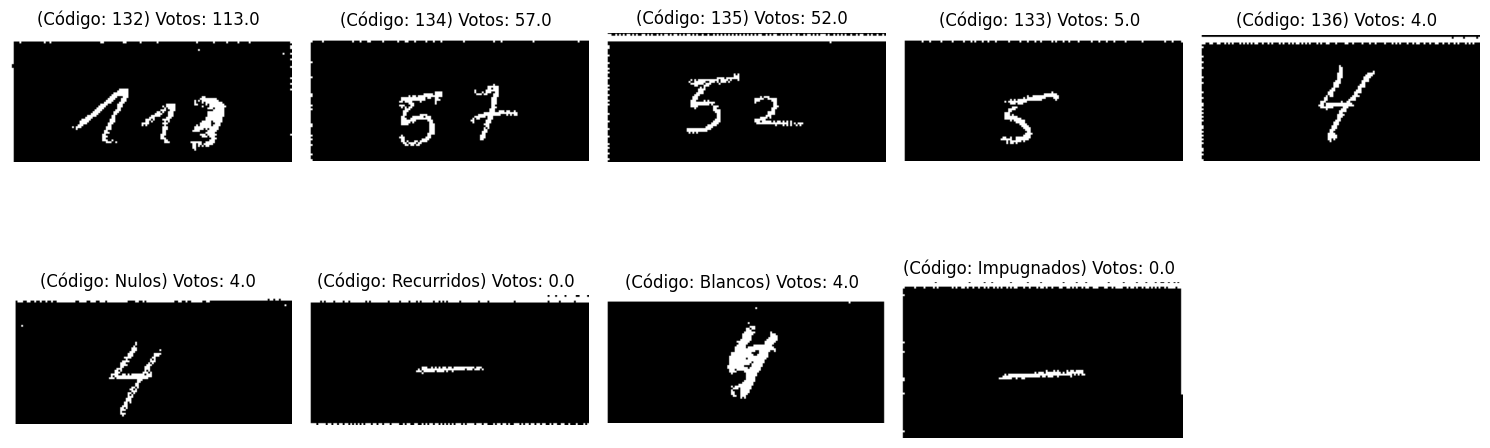

In [87]:
import random
import matplotlib.pyplot as plt

# Número de imágenes que quieres mostrar
numero_de_imagenes = len(resultados_info)  # Asegúrate de que esto refleje el número actual de imágenes

# Calcula cuántas filas y columnas necesitas
num_columnas_por_fila = 5  # o cualquier otro número de columnas que prefieras
num_filas = math.ceil(numero_de_imagenes / num_columnas_por_fila)

# Establece el tamaño de la figura
ancho_figura = num_columnas_por_fila * 3  # Ajusta el ancho como sea necesario
alto_figura = num_filas * 3  # Ajusta el alto como sea necesario
plt.figure(figsize=(ancho_figura, alto_figura))

# Asegúrate de que el 'dataset' no esté vacío
if dataset:
    # Selecciona un 'resultados_info' aleatorio del 'dataset'
    resultados_info_random = random.choice(dataset)

    # Imprimir un elemento aleatorio de los resultados
    for i, (codigo, info) in enumerate(resultados_info_random.items(), start=1):
        plt.subplot(num_filas, num_columnas_por_fila, i)
        if info.get("imagen") is not None:
            plt.imshow(info["imagen"], cmap='gray')
        plt.title(f"(Código: {codigo}) Votos: {info['votos']} ")
        plt.axis('off')

    plt.tight_layout()
    plt.show()
else:
    print("El dataset está vacío.")

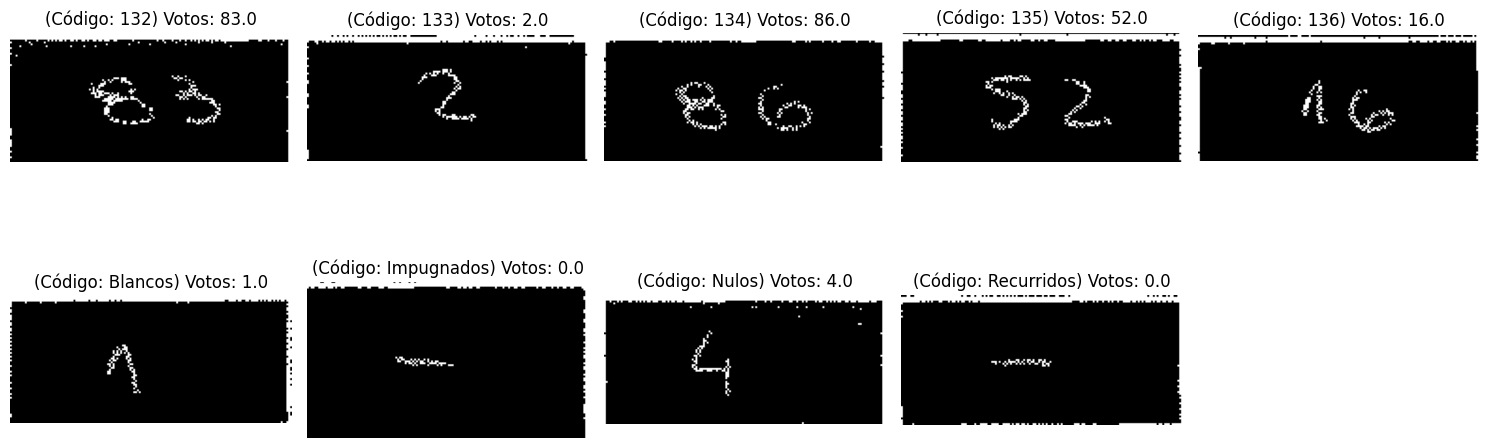

In [78]:
import matplotlib.pyplot as plt
import random
import math

# Si necesitas cargar los datos posteriormente:
all_data = storage.load_all()
# Asumiendo que all_data es el diccionario que contiene todos los datos cargados
if all_data:
    # Selecciona un archivo aleatorio del conjunto de datos
    file_name_random = random.choice(list(all_data.keys()))
    resultados_info_random = all_data[file_name_random]

    # Número de imágenes que quieres mostrar
    numero_de_imagenes = len(resultados_info_random)
    num_columnas_por_fila = 5  # Ajusta esto según prefieras
    num_filas = math.ceil(numero_de_imagenes / num_columnas_por_fila)

    # Establece el tamaño de la figura
    ancho_figura = num_columnas_por_fila * 3  # Ajusta el ancho como sea necesario
    alto_figura = num_filas * 3  # Ajusta el alto como sea necesario
    plt.figure(figsize=(ancho_figura, alto_figura))

    # Imprimir un elemento aleatorio de los resultados
    for i, (codigo, info) in enumerate(resultados_info_random.items(), start=1):
        plt.subplot(num_filas, num_columnas_por_fila, i)
        if info.get("imagen") is not None:
            plt.imshow(info["imagen"], cmap='gray')
        plt.title(f"(Código: {codigo}) Votos: {info['votos']}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()
else:
    print("El dataset está vacío.")